# Traditional Machine Learning Approach 
## Expired Prediction

Author - Samuel Holt (23087175)

Models tested:

- Logistic Regression
- Random Forest
- XGBoost

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone

# Packages
import numpy as np
import pandas as pd
import time

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

Mounted at /content/drive
/content/drive/MyDrive/Capstone


In [2]:
data = pd.read_csv('mortality.csv')
cols_to_rmv = ['Y', 'subject_id', 'stay_id', 'chiefcomplaint', 'in_date', 'expired', 'disposition']

In [3]:
# create stratified train and test splits and drop cols
# create function to make base model, test base model, grid search CSV model, show improvments

data['Y'] = data['expired']

data_sub = data.drop(columns=cols_to_rmv)
cat_cols = data_sub.select_dtypes('object').columns

data_sub = pd.get_dummies(data_sub, columns=cat_cols)
print(data_sub.columns)

y = data.Y
le =LabelEncoder()
le.fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(data_sub, y, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.astype('float64')

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

Index(['nights', 'hour', 'work_hours', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'critical', 'cardiac_arrest',
       'last_temperature', 'last_heartrate', 'last_resprate', 'last_o2sat',
       'last_sbp', 'last_dbp', 'last_pain', 'gender_F', 'gender_M',
       'arrival_transport_AMBULANCE', 'arrival_transport_HELICOPTER',
       'arrival_transport_OTHER', 'arrival_transport_UNKNOWN',
       'arrival_transport_WALK IN', 'race_class_ASIAN', 'race_class_BLACK',
       'race_class_LATINO', 'race_class_OTHER', 'race_class_WHITE'],
      dtype='object')


LOGISTIC REGRESSION: 
Recall: 0.05063291139240506 
F1: 0.06299212598425197


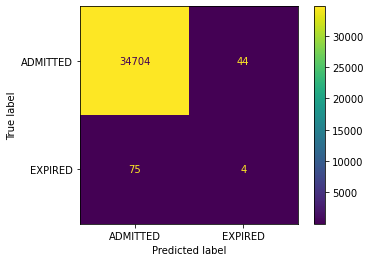

In [4]:
# get best params, train full model on train set
# get feat imps/SHAPs and conf mat/F1 on test set
scaler = StandardScaler().fit(X_test)

X_test_scaled = scaler.transform(X_test)

best_lr = LogisticRegression(C=1, penalty='l2')
best_lr.fit(X_train_scaled, y_train)
lr_preds = best_lr.predict(X_test_scaled)
print('LOGISTIC REGRESSION:',
      '\nRecall:', recall_score(y_test, lr_preds),
      '\nF1:', f1_score(y_test, lr_preds))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, lr_preds), 
                              display_labels=['ADMITTED', 'EXPIRED'])
disp.plot()

RANDOM FOREST: 
Recall: 0.24050632911392406 
F1: 0.3140495867768595


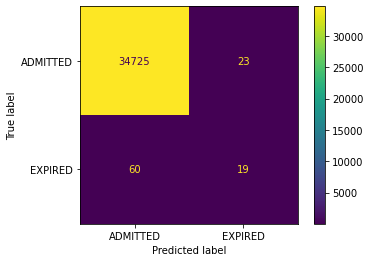

In [5]:
best_rf = RandomForestClassifier()
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)
print('RANDOM FOREST:',
      '\nRecall:', recall_score(y_test, rf_preds),
      '\nF1:', f1_score(y_test, rf_preds))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_preds), 
                              display_labels=['ADMITTED', 'EXPIRED'])
disp.plot()

XGBOOST: 
Recall: 0.35443037974683544 
F1: 0.4117647058823529


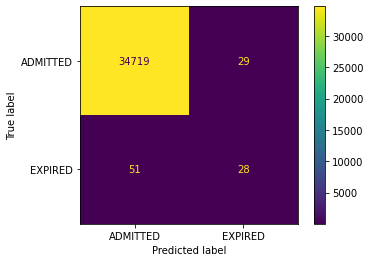

In [6]:
best_xgb = xgb.XGBClassifier()
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)
print('XGBOOST:', 
      '\nRecall:', recall_score(y_test, xgb_preds),
      '\nF1:', f1_score(y_test, xgb_preds))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_preds), 
                              display_labels=['ADMITTED', 'EXPIRED'])
disp.plot()

In [7]:
# Feat Imp for Rf
importances = best_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf.estimators_], axis=0)

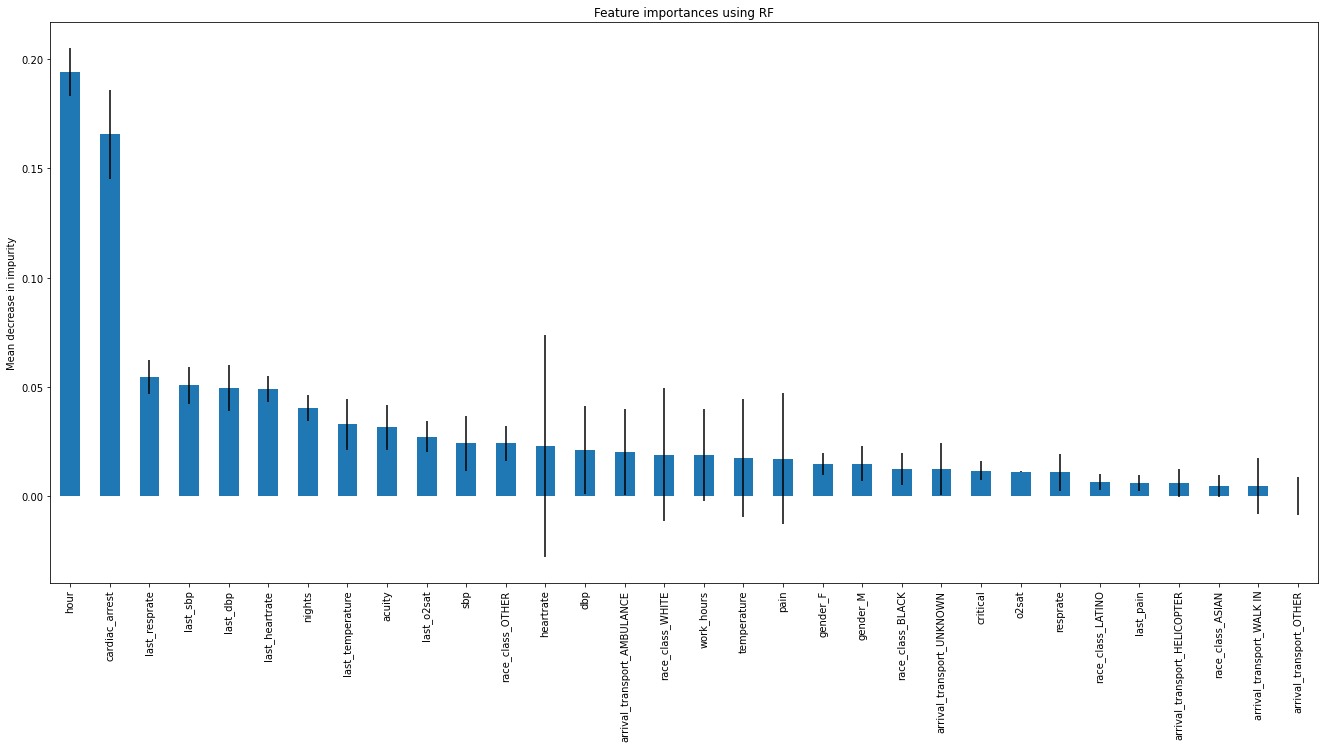

In [8]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=data_sub.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0.5, 0, 'Xgboost Feature Importance')

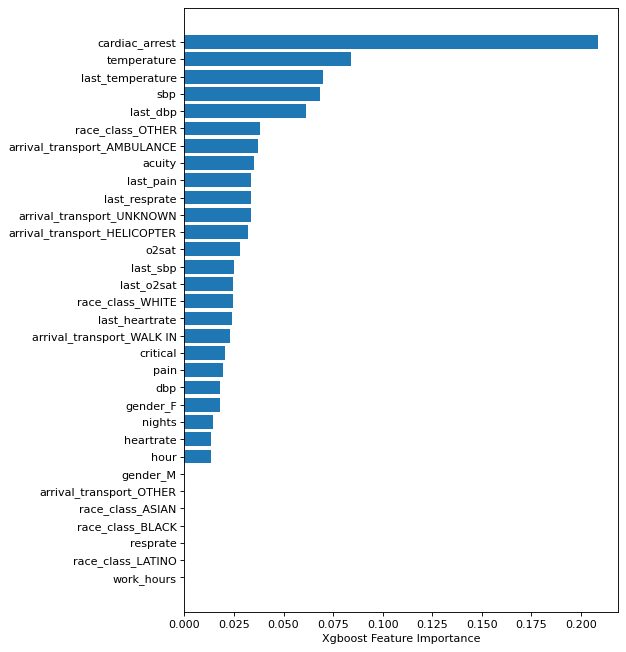

In [9]:
sorted_idx = best_xgb.feature_importances_.argsort()
from matplotlib.pyplot import figure

figure(figsize=(7, 10), dpi=80)
plt.barh(data_sub.columns[sorted_idx], best_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [10]:
! pip install shap

import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.8 MB/s 


In [11]:
explainer = shap.Explainer(best_xgb)
values = explainer(X_train[:2000])

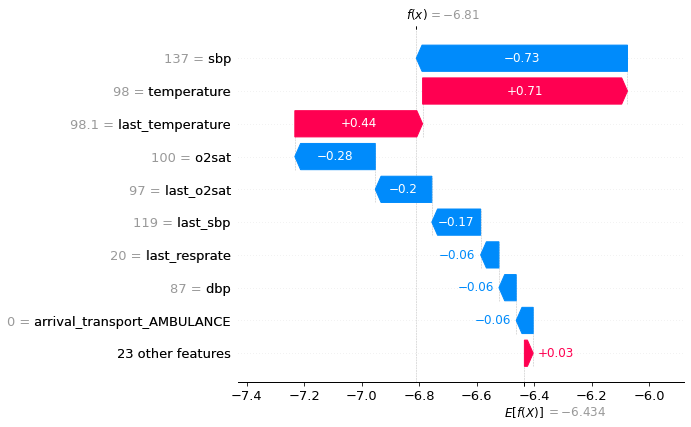

In [12]:
shap.plots.waterfall(values[0])

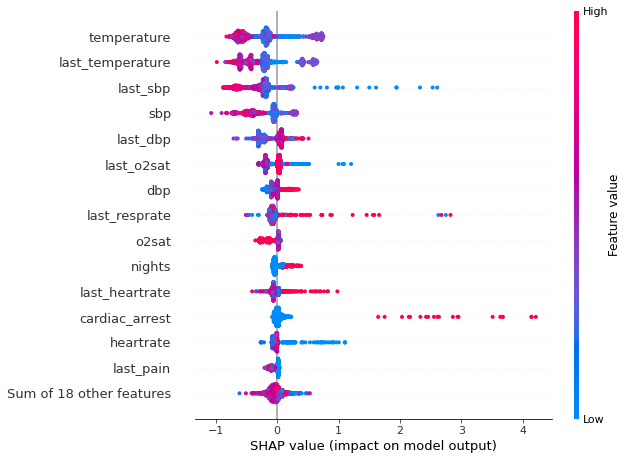

In [15]:
shap.plots.beeswarm(values, max_display=15)

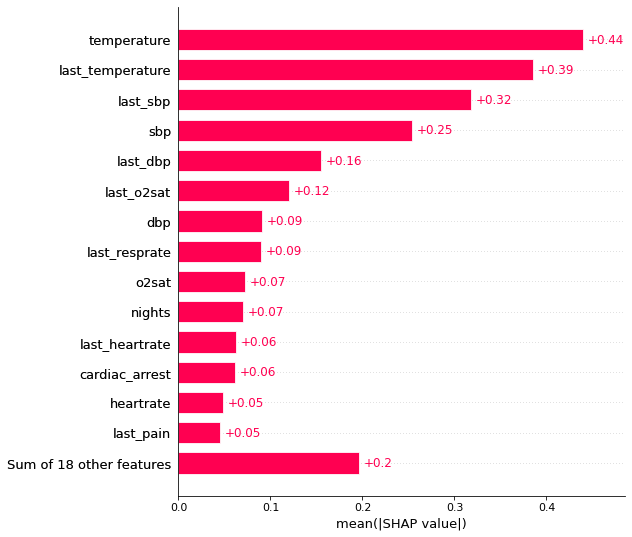

In [16]:
shap.plots.bar(values, max_display=15)